In [224]:
import CO2_Dataset_Preparation
import ML_Model_Master
import Result_Retriever

from CO2_Dataset_Preparation import *
from ML_Model_Master import *
from Result_Retriever import *
from datetime import datetime
import pickle

import importlib
importlib.reload(CO2_Dataset_Preparation)
importlib.reload(ML_Model_Master)
importlib.reload(Result_Retriever)

from CO2_Dataset_Preparation import *
from ML_Model_Master import *
from Result_Retriever import *


In [230]:
#Data parameters
position_number = 2
excess_rolls = [60,6000,36000] #these specify the rolling window on which a minimum is applied for excess 
feature_columns = ['Pic_CO2','Pic_CH4','ANEM_X','ANEM_Y','ANEM_Z','wd','ws']
downsample_sec = 600
periods_to_lag = 2
tower = 'Picarro'
train_percent = 0.8

#Model Parameters
activation = 'relu'
neurons = [256]
dropout_rate = [0.2]#,0.3]
learn_rate = [0.001]#,1e-4,1e-5]
decay = [1e-5]#,1e-6]
batch_size = [10]#,20,50]#,100]
epochs = [10]#,10]#,50,100]
error_metric = 'rmse'

#file_name = 'testlog'#'ML_Models/PN{}_DS{}_Lag{}_Neur{}_DR{}'.format(position_number,downsample_sec,periods_to_lag[0],neurons[0],dropout_rate[0])
#logfile=open('{}.txt'.format(file_name),'w')

logfile = None

In [231]:
#Preprocess data and save as pkl

data = Processed_Set(tower,position_number,excess_rolls,True)
data._retrieve_data('../CO2_Data_Processed/')
data._apply_excess()

ml_data = ML_Data(downsample_sec,periods_to_lag,tower,train_percent)
ml_data._ML_Process(data)

# with open('ML_dataset_{}DS.pkl'.format(downsample_sec), 'wb') as file:
#     pickle.dump(ml_data, file)

Applying excess using minimum on windows: [60, 6000, 36000]
Downsampling by mean at 600 seconds
Downsampling by mean at 600 seconds
Adding Wind Direction as 'wd'
Adding Wind Speed as 'ws'


In [232]:
try:
    print_log_flush("-------------------------BUILD AND TRAIN MODELS-------------------------",logfile)

    tot_train = len(neurons)*len(dropout_rate)*len(learn_rate)*len(decay)*len(batch_size)*len(epochs)-1

    models = []
    i = 0


    for neur in neurons:
        for dr in dropout_rate:
            for lr in learn_rate:
                for dec in decay:
                    for bs in batch_size:
                        for ep in epochs:
                            print_log_flush(f"---Training Model: {i} of {tot_train}---",logfile)
                            ml_model = ML_Model_Builder(activation,neur,dr,lr,dec,bs,ep)
                            ml_model._train_model(ml_data)
                            #delattr(ml_model,'logfile')
                            models.append(ml_model)
                            print(models)
                            i+=1

    error_name  = 'rmse'   

    error_vals = []
    for m in models:
        error_vals.append(m.history.history[error_name][-1])
    best_idx = error_vals.index(min(error_vals))

    print_log_flush("-------------------------RESULTS-------------------------",logfile)

    print_log_flush(f"Best score for '{error_name}' was {min(error_vals)} in model {best_idx}",logfile)

    print_log_flush(f"Downsampling Seconds: {models[best_idx].downsample_sec}\n\
    Lag Periods: {models[best_idx].periods_to_lag}\n\
    Activation: {models[best_idx].activation}\n\
    Neurons: {models[best_idx].neurons}\n\
    Learning Rate: {models[best_idx].learn_rate}\n\
    Decay: {models[best_idx].decay}\n\
    Epochs: {models[best_idx].epochs}",logfile)

    print_log_flush("-------------------------SAVE FILE-------------------------",logfile)

    with open('{}.pkl'.format(file_name), 'wb') as models_file:
         pickle.dump(models, models_file)

    print_log_flush(f"Saved list of models to {file_name}",logfile)
    print_log_flush(f"Models built with optimizer: {models[best_idx].opt_string}",logfile)

    now = datetime.now()
    dt_string = now.strftime("%Y/%m/%d %H:%M:%S")
    print_log_flush('*******************************END TIME = {}************************************'.format(dt_string),logfile)
except Exception as e:
    print_log_flush('Error occurred ' + str(e),logfile)
if logfile is not None:
    logfile.close()

-------------------------BUILD AND TRAIN MODELS-------------------------
---Training Model: 0 of 0---
Downsampling = 600
Lag Periods = 2        
activation=relu
neurons=256
dropout_rate=0.2        
learn_rate=0.001
decay=1e-05
batch size=10
epochs=10
Train on 1032 samples, validate on 259 samples
Epoch 1/10
1032/1032 [==============================] - 3s 3ms/step - loss: 0.0989 - rmse: 0.2723 - val_loss: 0.0907 - val_rmse: 0.2448
Epoch 2/10
1032/1032 [==============================] - 2s 1ms/step - loss: 0.0739 - rmse: 0.2286 - val_loss: 0.0821 - val_rmse: 0.2337
Epoch 3/10
1032/1032 [==============================] - 2s 2ms/step - loss: 0.0641 - rmse: 0.2045 - val_loss: 0.0763 - val_rmse: 0.2138
Epoch 4/10
1032/1032 [==============================] - 2s 2ms/step - loss: 0.0578 - rmse: 0.1851 - val_loss: 0.0741 - val_rmse: 0.1958
Epoch 5/10
1032/1032 [==============================] - 2s 2ms/step - loss: 0.0537 - rmse: 0.1743 - val_loss: 0.0685 - val_rmse: 0.1848
Epoch 6/10
1032/1032 [

/uufs/chpc.utah.edu/common/home/u0890904/software/pkg/miniconda3/envs/CO2_Eddy/lib/python3.7/site-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


Fitting data from X_test


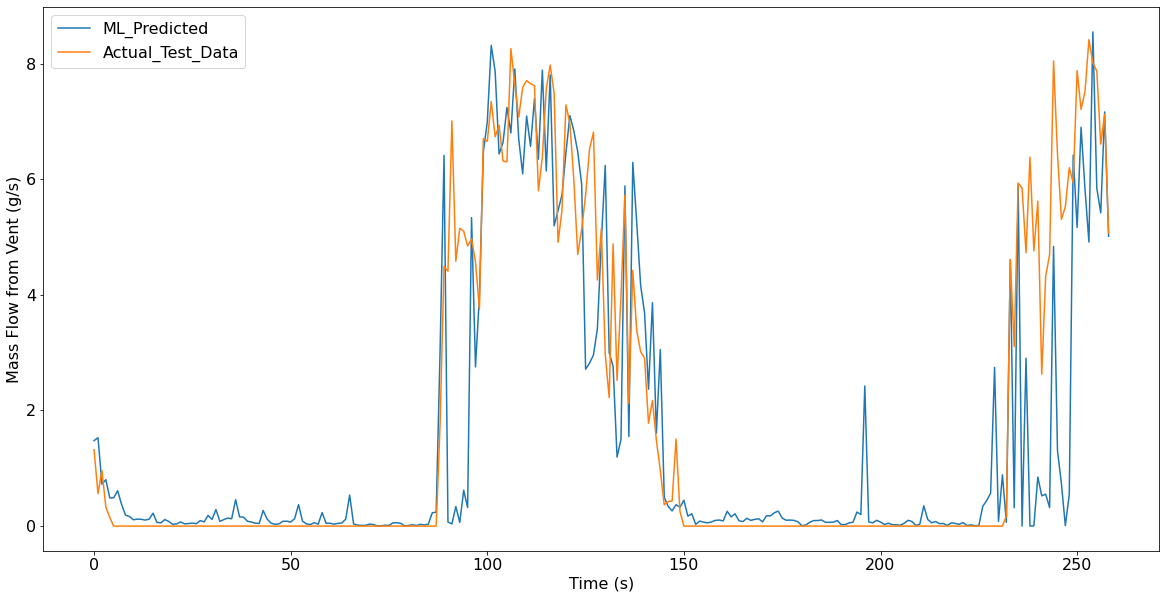

In [167]:
import matplotlib.pyplot as plt

i=best_idx

models[i]._fit_data(ml_data)

#Return to original data shape and scale
X_test_original_shape = ml_data.X_test.reshape(ml_data.orig_X_test_shape) #reshape from 3d time
y_test_original_shape = ml_data.y_test.reshape(ml_data.orig_y_test_shape)#reshape from 3d time 

merged_tests = np.concatenate((X_test_original_shape,y_test_original_shape[:,None]),axis=1) #concat X and y
unscaled_test = pd.DataFrame(ml_data.min_max_scalar.inverse_transform(merged_tests)).iloc[:,-1] #unscale using declared scalar

y_fit_original_shape = ml_data.y_fit.reshape(ml_data.orig_y_test_shape)
merged_tests = np.concatenate((X_test_original_shape,y_fit_original_shape[:,None]),axis=1)
unscaled_fit = pd.DataFrame(ml_data.min_max_scalar.inverse_transform(merged_tests)).iloc[:,-1]

#Put into pandas df
comparison = pd.concat([unscaled_test,unscaled_fit],axis=1)
comparison.columns = ['test','fit']

#PLOT PREDICTED VS OBSERVED
fig, ax = plt.subplots(figsize = (20,10))
# ax.plot(ml_data.y_fit,label='ML_Fit_to_Test')
# ax.plot(ml_data.y_test,label='Actual_Test_Data')

roll = 1

ax.plot(comparison['fit'].rolling(roll).mean(),label='ML_Predicted')
ax.plot(comparison['test'].rolling(roll).mean(),label='Actual_Test_Data')

ax.set_xlabel('Time (s)',fontsize=16)
ax.set_ylabel('Mass Flow from Vent (g/s)',fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)


ax.legend(fontsize=16)
plt.show()

-----Generating Data Variables-----
-----Reading Model Outputs-----
-----Finding Best Model-----
Best Model Index = 0
-----Setup Data for Best Model Retrain-----
Applying excess using minimum on windows: [60, 6000, 36000]
Downsampling by mean at 600 seconds
Downsampling by mean at 600 seconds
Adding Wind Direction as 'wd'
Adding Wind Speed as 'ws'
-----Regenerating Best Model-----
-----Retraining Best Model-----
Downsampling = 600
Lag Periods = 1        
activation=relu
neurons=128
dropout_rate=0.2        
learn_rate=0.001
decay=1e-05
batch size=10
epochs=10
Train on 699 samples, validate on 175 samples
Epoch 1/10
699/699 [==============================] - 2s 3ms/step - loss: 0.1421 - rmse: 0.3557 - val_loss: 0.1299 - val_rmse: 0.3174
Epoch 2/10
699/699 [==============================] - 1s 828us/step - loss: 0.0726 - rmse: 0.2367 - val_loss: 0.1513 - val_rmse: 0.3020
Epoch 3/10
699/699 [==============================] - 1s 776us/step - loss: 0.0631 - rmse: 0.2027 - val_loss: 0.1469 - 

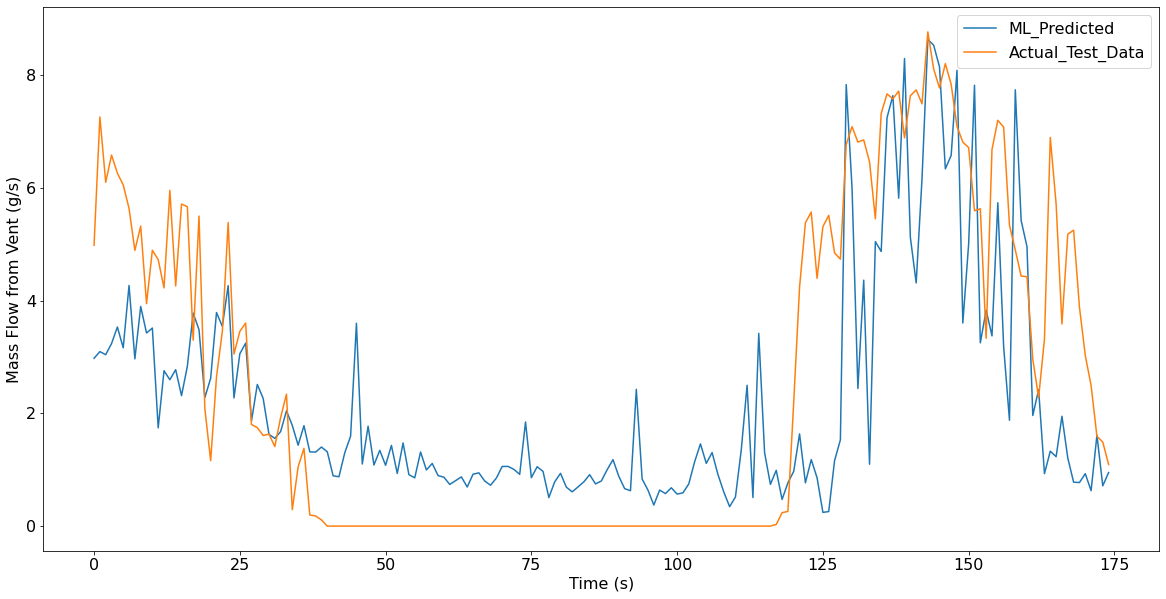

In [225]:
from Result_Retriever import *

logfile = f'Gridsearch_Output/Picarro_PN1_DS600_Lag1_Train0.8.out'
g = Gridsearch_Result_Retrieve(logfile)
g._read_data_vars()
g._read_models()
g._find_best_model()
g._get_best_data('../CO2_Data_Processed/')
g._retrain_fit_best()
g._plot_best_comparison(1)

In [13]:
l = g.last_error
from operator import itemgetter
top_ten = sorted(enumerate(l),key=itemgetter(1))[0:10]
top_idx = [i[0]for i in top_ten]
top_models = []
for i in top_idx:
    top_models.append(g.models[i])
top_attr = {'neurons':[],'dropout_rate':[],'learn_rate':[],'decay':[],'batch_size':[],'epochs':[]}
for mod in top_models:
    top_attr['neurons'].append(mod.neurons)
    top_attr['dropout_rate'].append(mod.dropout_rate)
    top_attr['learn_rate'].append(mod.learn_rate)
    top_attr['decay'].append(mod.decay)
    top_attr['batch_size'].append(mod.batch_size)
    top_attr['epochs'].append(mod.epochs)

In [ ]:
file_name ='g'
with open('{}.pkl'.format(file_name), 'wb') as file:
    pickle.dump(g, file)

In [3]:
file_name ='g'
with open('{}.pkl'.format(file_name), 'rb') as file:
    g = pickle.load(file)

/uufs/chpc.utah.edu/common/home/u0890904/software/pkg/miniconda3/envs/CO2_Eddy/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
